**Predictive analysis, target feature: Event_type**

Choosing the type of epileptic seizure as a target category, based on duration (IED, Mini, and full Seizures) as a target category can have significant value in improving treatment accuracy, patient monitoring, resource allocation, and risk management, offering a more personalized and effective approach in managing epilepsy.

#Data preprocessing

**Load libraries**

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
path = '/content/drive/MyDrive/eeg data/totall_df.csv'

In [82]:
df = pd.read_csv(path)
df.tail()

,Example_names,F1_th/al,F1_th/beta,F1_th/gama,F2_th/al,F2_th/beta,F2_th/gama,T1_th/al,T1_th/beta,T1_th/gama,...,O1_th/gama,O2_th/al,O2_th/beta,O2_th/gama,Example,Day_time_h,Event_type,SFN_treat,Num_per_h,Dur_per_h
3322,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.376390,0.808605,14.442618,0.354407,0.646204,12.138190,0.413740,0.983833,23.487378,...,13.437017,0.360715,0.590758,7.511864,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3323,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.444862,0.883468,14.071816,0.413103,0.788776,13.421757,0.410607,0.911440,20.187075,...,14.771327,0.456566,0.861803,11.286298,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3324,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.471139,0.874434,11.718948,0.449249,0.813695,11.918224,0.431847,0.903160,16.261716,...,13.442645,0.508233,0.921530,9.931513,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3325,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.377731,0.824558,13.373822,0.348138,0.699460,12.694106,0.371347,0.898335,16.742484,...,13.953187,0.369664,0.693528,9.799755,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3326,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.534603,1.093385,19.617927,0.472650,0.777563,13.089325,0.474034,1.066304,24.289437,...,20.030298,0.517533,0.879643,13.251053,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0


In [83]:
df.shape

(3327, 31)

Final column manupulations, dropping columns 'Example_names', 'Example', 'Dur_per_h', 'Num_per_h'. To address multicollinearity with the target label, the columns 'Example_names' and 'Example' were excluded from the dataset. Additionally, the colums  'Dur_per_h' 'Num_per_h' were removed due to their high multicollinearity with the target label 'Event-type'.

In [84]:
# Column manupulations
df_transformed = df.drop(columns = ['Example_names', 'Example', 'Dur_per_h','Num_per_h'])
df_transformed['Event_type'] = df_transformed['Event_type'].replace ('Seizure', 'SEIZURE')

df_transformed = df_transformed[[col for col in df_transformed.columns if col !='Event_type'] + ['Event_type']]

print (df_transformed.columns)
df_transformed['Event_type'].unique()

Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Day_time_h',
       'SFN_treat', 'Event_type'],
      dtype='object')


array(['IED', 'MS', 'SEIZURE'], dtype=object)

In [85]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3327 entries, 0 to 3326
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   F1_th/al    3327 non-null   float64
 1   F1_th/beta  3327 non-null   float64
 2   F1_th/gama  3327 non-null   float64
 3   F2_th/al    3327 non-null   float64
 4   F2_th/beta  3327 non-null   float64
 5   F2_th/gama  3327 non-null   float64
 6   T1_th/al    3327 non-null   float64
 7   T1_th/beta  3327 non-null   float64
 8   T1_th/gama  3327 non-null   float64
 9   T2_th/al    3327 non-null   float64
 10  T2_th/beta  3327 non-null   float64
 11  T2_th/gama  3327 non-null   float64
 12  P1_th/al    3327 non-null   float64
 13  P1_th/beta  3327 non-null   float64
 14  P1_th/gama  3327 non-null   float64
 15  P2_th/al    3327 non-null   float64
 16  P2_th/beta  3327 non-null   float64
 17  P2_th/gama  3327 non-null   float64
 18  O1_th/al    3327 non-null   float64
 19  O1_th/beta  3327 non-null  

# Checking data for multicollinearity

In [86]:
# Define the feature groups: numerical and categorical
numerical_features = df_transformed.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df_transformed.select_dtypes(include=['object']).columns
print ('Numerical features:')
print (numerical_features)
print ('Categorical features:')
print (categorical_features)

Numerical features:
Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama'],
      dtype='object')
Categorical features:
Index(['Day_time_h', 'SFN_treat', 'Event_type'], dtype='object')


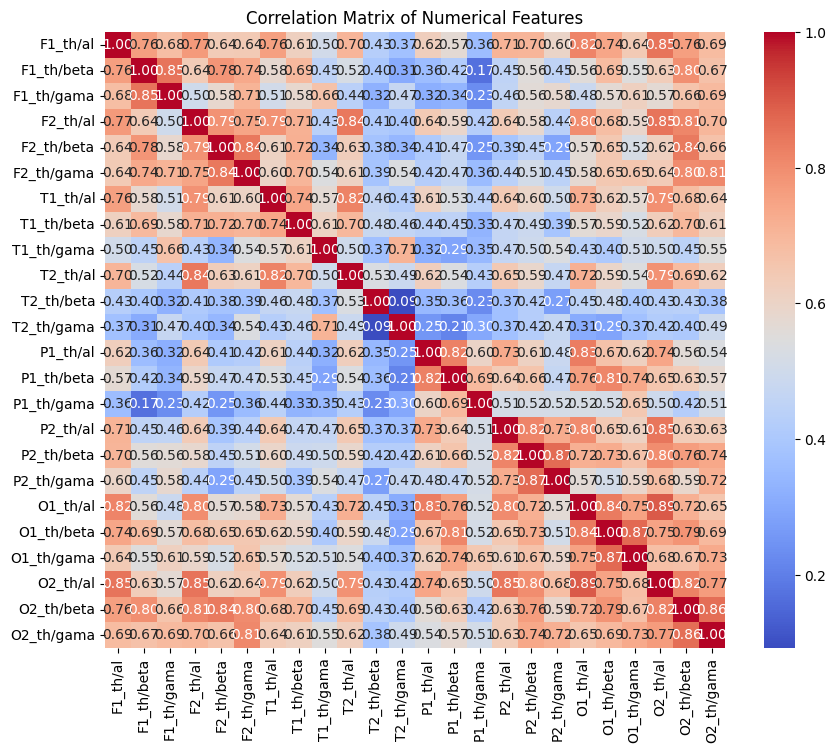

In [87]:
correlation_matrix = df_transformed[numerical_features].corr()

# Correlation matrix visualization

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [88]:
# Choose labels with correlation > 0.9
high_corr_pairs = np.where(correlation_matrix > 0.9)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                   for i, j in zip(*high_corr_pairs) if i != j]
high_corr_pairs

[]

**Checking relations between numerical features and target (categorical) feature**

To examine the relationship between numerical features and a categorical variable, we used an ANOVA (for many categories). It allows us to check whether there are statistically significant differences in the mean values of numerical features for different categories of the target variable.

In [89]:
from scipy.stats import f_oneway

results = []

for feature in numerical_features:
    groups = [df_transformed[df_transformed['Event_type'] == category][feature] for category in df_transformed['Event_type'].unique()]
    f_stat, p_value = f_oneway(*groups)

    results.append({
        'Feature': feature,
        'F-statistic': f_stat,
        'p-value': p_value
    })

results_df = pd.DataFrame(results)


results_df.to_excel('anova_results.xlsx', index=False)
results_df.round(4)

,Feature,F-statistic,p-value
0,F1_th/al,47.2389,0.0
1,F1_th/beta,85.1704,0.0
2,F1_th/gama,95.3934,0.0
3,F2_th/al,97.2627,0.0
4,F2_th/beta,136.6632,0.0
5,F2_th/gama,145.8232,0.0
6,T1_th/al,112.1911,0.0
7,T1_th/beta,197.8793,0.0
8,T1_th/gama,225.5452,0.0
9,T2_th/al,92.3857,0.0


Conclusion:

All the features are statistically significant, as their p-value is less than 0.05, indicating that they are significant in the context of the categorical variable.

**Checking relations between categorical and target features**

In [90]:
# Create a contingency table for two independent variables and a dependent variable and conducting a chi-square test
from scipy.stats import chi2_contingency

contingency_table_1 = pd.crosstab([df_transformed['Day_time_h']], df_transformed['Event_type'])
chi2_stat_1, p_value_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)

In [91]:
contingency_table_2 = pd.crosstab([df_transformed['SFN_treat']], df_transformed['Event_type'])

chi2_stat_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingency_table_2)

In [92]:
# Defining target column
X= df_transformed.drop(columns = ['Event_type'])
y = df_transformed['Event_type']

In [93]:
# Creating DataFrame with results
results = pd.DataFrame({
    'Feature': ['Day_time_h', 'Event_type'],
    'Chi-Square Statistic': [chi2_stat_1, chi2_stat_2],
    'P-value': [p_value_1, p_value_2],
    'Degrees of Freedom': [dof_1, dof_2]
})
# Saving into Excel file
results.to_excel('chi_square_results_events.xlsx', index=False)
results

,Feature,Chi-Square Statistic,P-value,Degrees of Freedom
0,Day_time_h,2.10038,0.349871,2
1,Event_type,7.05859,0.029326,2


**Conclusion to 'SFN_treat':**
P-value = 0.0293, which is less than the significance level of 0.05, rejects the null hypothesis.
The null hypothesis states that there is no statistically significant relationship between the variables.
Since the p-value is less than 0.05, we can conclude that there is a statistically significant relationship between the variables 'Event_type' and 'SFN_treat'.
This means that changes in the values of one variable are likely associated with changes in the other variable.

**Conclusion to 'Day_time_h'**
P-value = 0.3498, which is much greater than the significance level of 0.05, means we fail to reject the null hypothesis.
Null Hypothesis: There is no statistically significant relationship between the two variables (they are independent).
Since the p-value is so large, we conclude that the two variables are likely independent of each other.
If a variable has a p-value greater than 0.05, this indicates that its effect on the outcome is not statistically significant enough and it can be excluded.
So, we may drop it from the model because its impact on the results is insignificant and it may only increase the complexity of the model without improving its performance.

In [94]:
# By the results obrained we in addition can remove variables 'Day_time_h'
df_finish = df_transformed.drop(columns = ['Day_time_h'])
df_finish.columns

Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'SFN_treat',
       'Event_type'],
      dtype='object')

# Model Pipeline

In [95]:
# Defining target column
X= df_finish.drop(columns = ['Event_type'])
y = df_finish['Event_type']

In [96]:
# Setting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2661, 25), (666, 25), (2661,), (666,))

In [97]:
numerical_attributes = X.select_dtypes(include=['float64', 'int64']).columns
categorical_attributes = X.select_dtypes(include=['object']).columns

In [98]:
# Transforming target feature to binary format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [99]:
# Check the mapping in encoded y_train (event_type):
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Class mapping: {'IED': 0, 'MS': 1, 'SEIZURE': 2}


In [100]:
numerical_pipeline = Pipeline([

    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [101]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_attributes),
        ('cat', categorical_pipeline, categorical_attributes)
    ]
)

In [102]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=4, eta=0.1, n_estimators=100))
])

In [103]:
model.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None, num_class=3, ...))])

In [104]:
import pickle

model_path = "xgb_model_events.pkl"
with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)

#Model cross-validation

In [105]:
# Validation of train data accuracy
cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean accuracy: {np.mean(cv_scores)}')
print(f'Standard deviation: {np.std(cv_scores)}')

Cross-validation scores: [0.72420263 0.71992481 0.71428571 0.69172932 0.70112782]
Mean accuracy: 0.7102540591629166
Standard deviation: 0.012089618081089283


In [106]:
# Predictions and evaluations
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='macro')
recall = recall_score(y_test_encoded, y_pred, average='macro')
f1 = f1_score(y_test_encoded, y_pred, average='macro')
report = classification_report(y_test_encoded, y_pred)

In [107]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(report)

Accuracy: 0.6936936936936937
Precision: 0.6125957628689869
Recall: 0.5773731881830326
F1 Score: 0.5754279050163366
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       194
           1       0.43      0.18      0.26       126
           2       0.73      0.91      0.81       346

    accuracy                           0.69       666
   macro avg       0.61      0.58      0.58       666
weighted avg       0.66      0.69      0.66       666



In general, the model performs better for class 2, i.e. full seizures, but the results for class 0 (IEDs) and especially for class 1 (mini-seizures) are not good enough to make accurate predictions.

In [108]:
with open('classification_report_modell_events.txt', 'w') as file:
    file.write(report)

# Model accuracy visualization

**Visualization Precision-Recall curve**

In [109]:
# Probabilities for train and test data
y_train_prob = model.predict_proba(X_train)
y_test_prob = model.predict_proba(X_test)

In [110]:
# OneHotCoding for target label : train and test
encoder = OneHotEncoder(sparse_output=False)

y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

In [111]:
# Class number
n_classes = y_train_encoded.shape[1]

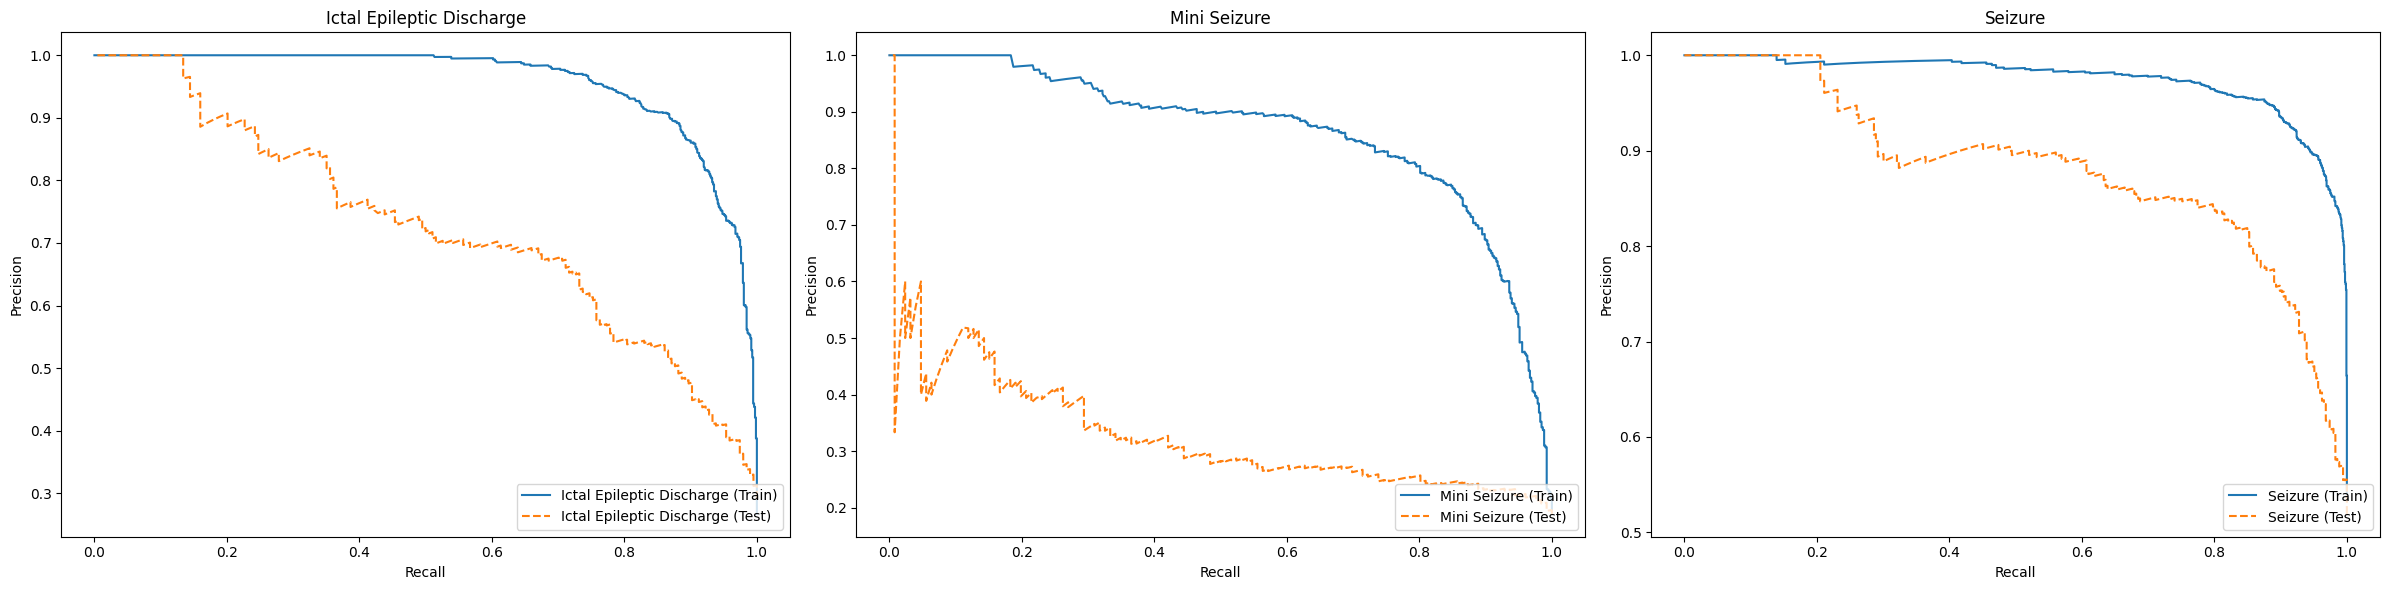

In [74]:
# Initialising lists to save curve precision-recall values
precision_train = {}
recall_train = {}
precision_test = {}
recall_test = {}

# Defining class names
class_names = ['Ictal Epileptic Discharge', 'Mini Seizure', 'Seizure']

# Calculation precision-recall curves for each class
for i in range(n_classes):
    precision_train[i], recall_train[i], _ = precision_recall_curve(y_train_encoded[:, i], y_train_prob[:, i])
    precision_test[i], recall_test[i], _ = precision_recall_curve(y_test_encoded[:, i], y_test_prob[:, i])

fig, axes = plt.subplots(1, n_classes, figsize=(8 * n_classes, 6))

for i in range(n_classes):
    axes[i].plot(recall_train[i], precision_train[i], label=f'{class_names[i]} (Train)')
    axes[i].plot(recall_test[i], precision_test[i], label=f'{class_names[i]} (Test)', linestyle='--')

    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'{class_names[i]}')
    axes[i].legend(loc='lower right')
plt.tight_layout()
plt.savefig('Precision-Recall Curve(model_events).png')
plt.show()


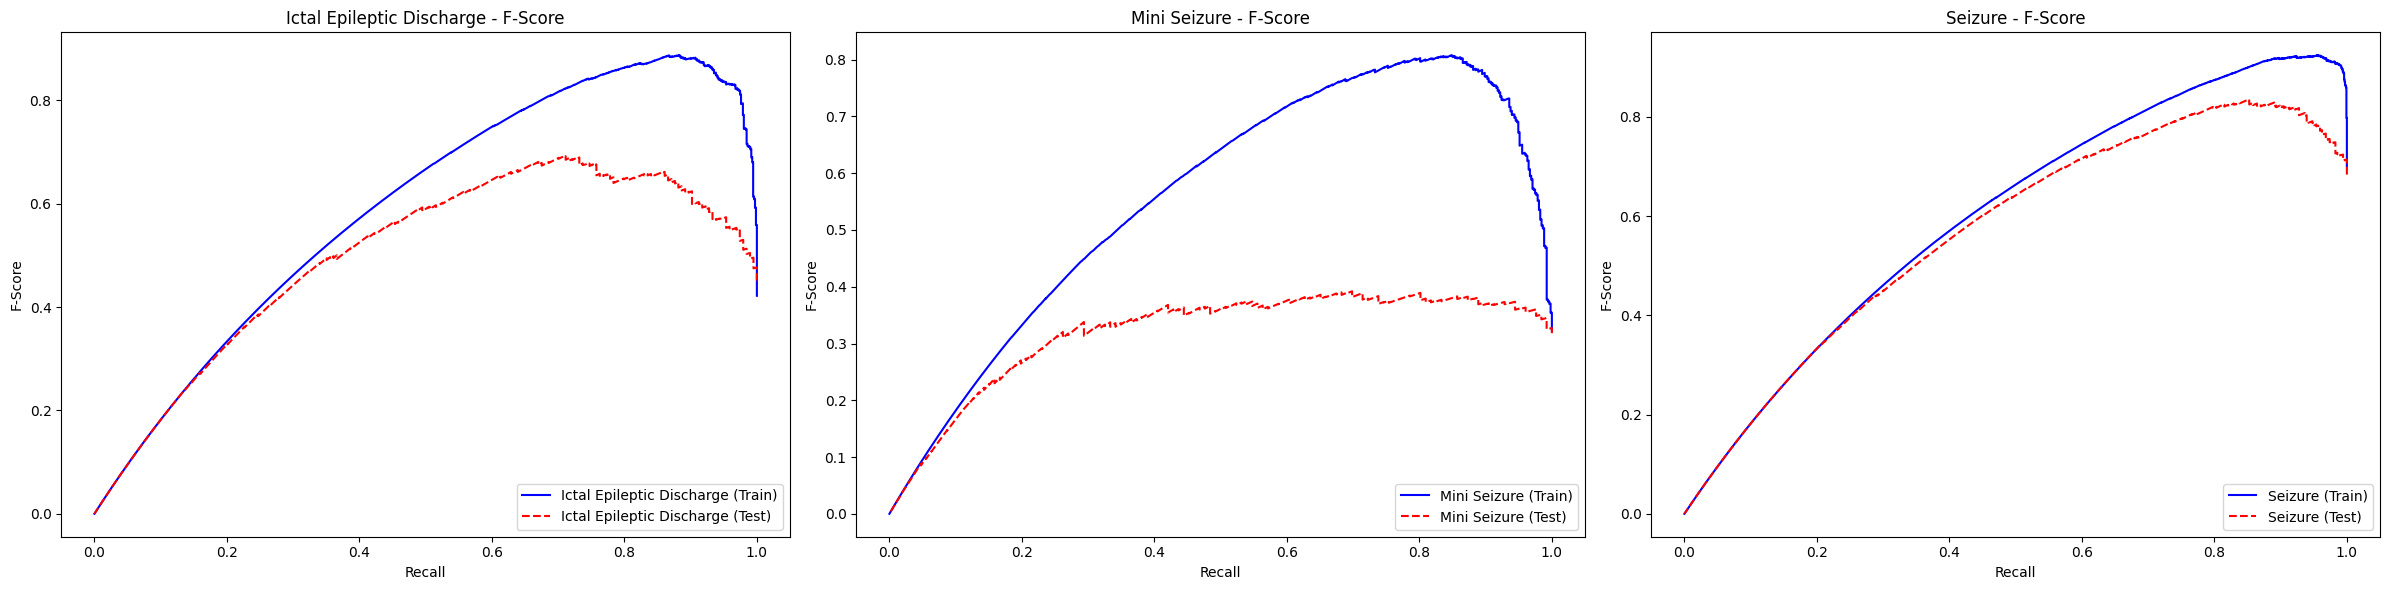

In [75]:
n_classes = y_train_encoded.shape[1]

# Initialize dictionaries to store F1 score curves
fscore_train = {}
fscore_test = {}

# Calculate F1 score curves for each class
for i in range(n_classes):
    fscore_train[i] = 2 * (precision_train[i] * recall_train[i]) / (precision_train[i] + recall_train[i])
    fscore_test[i] = 2 * (precision_test[i] * recall_test[i]) / (precision_test[i] + recall_test[i])


fig, axes = plt.subplots(1, n_classes, figsize=(8 * n_classes, 6))

for i in range(n_classes):
    axes[i].plot(recall_train[i], fscore_train[i], label=f'{class_names[i]} (Train)', color='blue')
    axes[i].plot(recall_test[i], fscore_test[i], label=f'{class_names[i]} (Test)', linestyle='--', color='red')

    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('F-Score')
    axes[i].set_title(f'{class_names[i]} - F-Score')
    axes[i].legend(loc='lower right')

plt.tight_layout()
plt.savefig('F-Score Curve(model_events).png')
plt.show()

#Defining features' impotance

In [76]:
importances = model.named_steps['classifier'].feature_importances_

In [77]:
# Getting all columns after transformation
categorical_columns_transformed = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_attributes)
all_feature_names = list(np.concatenate([numerical_attributes, categorical_columns_transformed]))
all_feature_names

['F1_th/al',
 'F1_th/beta',
 'F1_th/gama',
 'F2_th/al',
 'F2_th/beta',
 'F2_th/gama',
 'T1_th/al',
 'T1_th/beta',
 'T1_th/gama',
 'T2_th/al',
 'T2_th/beta',
 'T2_th/gama',
 'P1_th/al',
 'P1_th/beta',
 'P1_th/gama',
 'P2_th/al',
 'P2_th/beta',
 'P2_th/gama',
 'O1_th/al',
 'O1_th/beta',
 'O1_th/gama',
 'O2_th/al',
 'O2_th/beta',
 'O2_th/gama',
 'SFN_treat_No_SFN',
 'SFN_treat_SFN']

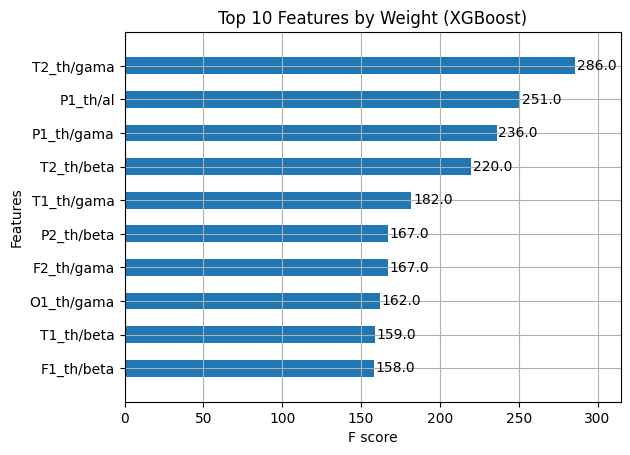

In [78]:
# Extract the XGBoost model
classifier = model.named_steps['classifier']

# Set feature names for PCA components in XGBoost
classifier.get_booster().feature_names = all_feature_names

# Plot feature importance
xgb.plot_importance(
    classifier,
    importance_type='weight',
    max_num_features=10,
    height=0.5
)

plt.title("Top 10 Features by Weight (XGBoost)")
plt.savefig('Top 10 Features by Weight (XGBoost).png')
plt.show()

**Conclusions:**
1. Our model demonstrated the highest accuracy in predicting full-time seizures (F-score = 0.81), compared to IED (F-score = 0.66) and Mini Seizures (F-score = 0.26).
2. The biomarkers identified for this prognosis include the ratio of theta to gamma and theta to beta frequency bands across all cortical areas studied (frontal, temporal, parietal, and occipital), without significant interhemispheric asymmetry.







It is also worth noting that the accuracy of the model, even for full-time seizures, is significantly worse than the accuracy of the model where the target feature was the presence or absence of sulforaphane treatment (predictive analysis was performed on the same data and using the same algorithms for data preprocessing, pipelining and training of the XGBoostClassifier model).